In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import numpy as np
from sklearn.datasets import make_moons
from math import pi
import matplotlib.pyplot as plt

In [2]:
n_samples = 2_500
data, _ = make_moons(n_samples=n_samples, noise=0.05)
#data = data.astype("float64")

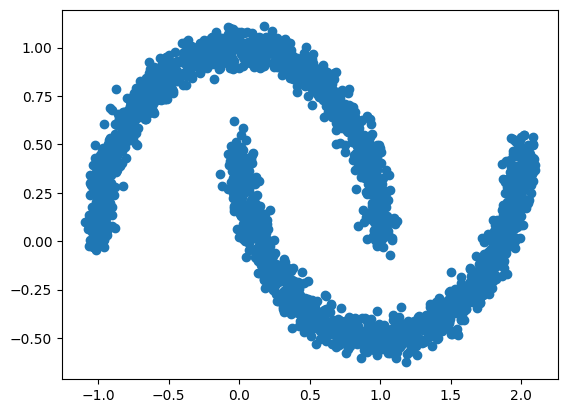

In [3]:
fig=plt.scatter(data[:,0], data[:,1])

In [4]:
# Define a simple normalizing flow using affine coupling layers
class AffineCoupling(keras.layers.Layer):
    def __init__(self, widths, swap):
        super(AffineCoupling, self).__init__()
        
        self.scale_net = keras.Sequential([
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(1, activation='softplus')
        ])
        self.translate_net = keras.Sequential([
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(1)
        ])
        self.swap = swap
        self.widths = widths

    def call(self, x, backward=False):
        if self.swap:
            x2, x1 = keras.ops.split(x, indices_or_sections=2, axis=1)
        else:
            x1, x2 = keras.ops.split(x, indices_or_sections=2, axis=1)

        scaling = self.scale_net(x1)
        translation = self.translate_net(x1)

        if backward:
            y2 = x2 * scaling + translation
            log_det_jac = keras.ops.log(scaling)
        else:
            y2 = (x2 - translation) / scaling
            log_det_jac = -keras.ops.log(scaling)

        if self.swap:
            y = keras.ops.concatenate([y2, x1], axis=1)
        else:
            y = keras.ops.concatenate([x1, y2], axis=1)

        return y, log_det_jac

In [5]:
class NormalizingFlow(keras.Model):
    def __init__(self, depth, widths):
        super(NormalizingFlow, self).__init__()
        self.coupling_layers = [AffineCoupling(widths=widths, swap=(i % 2 == 0)) for i in range(depth)]

    def forward(self, x):
        log_det_jac = keras.ops.zeros(x[...,:1].shape)

        z = x
        for layer in self.coupling_layers:
            z, ldj = layer(z)
            log_det_jac = log_det_jac + ldj

        return z, log_det_jac

    def backward(self, z):
        log_det_jac = keras.ops.zeros(z[...,:1].shape)

        x = z
        for layer in reversed(self.coupling_layers):
            x, ldj = layer(x, backward=True)
            log_det_jac = log_det_jac + ldj
        
        return x, log_det_jac

    def log_prob(self, x):
        z, log_det_jac = self.forward(x)
        log_prob = self.log_prob_base(z) + log_det_jac

        return log_prob

    def log_prob_base(self, z):
        kernel = -0.5 * keras.ops.sum(z ** 2, axis=-1)
        
        return kernel

    def sample(self, n_samples):
        z = keras.random.normal((n_samples, 2))
        x, _ = self.backward(z)

        return x



In [6]:
flow = NormalizingFlow(depth=8, widths=[8, 4])

In [7]:
epochs=200
batch_size=100

In [8]:
schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=epochs * n_samples // batch_size)
optimizer = keras.optimizers.Adam(schedule, global_clipnorm=1.0)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(data.astype("float64"))
dataset = dataset.batch(batch_size)

In [10]:
def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = - model.log_prob(x)
        loss = tf.reduce_mean(loss)
    
    g = tape.gradient(loss, model.trainable_variables)
    return g, loss   

In [11]:
losses = []
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in dataset:
        g, loss = train_step(flow, batch)
        optimizer.apply_gradients(zip(g, flow.trainable_variables))
        epoch_loss += loss.numpy()
    epoch_loss = epoch_loss / len(dataset)
    losses.append(epoch_loss)
    
    print("epoch: ", epoch+1, "\tloss: ", epoch_loss)



epoch:  1 	loss:  2.597054203748703
epoch:  2 	loss:  0.13400557558983564
epoch:  3 	loss:  -0.12545111820101737
epoch:  4 	loss:  -0.31871203899383543
epoch:  5 	loss:  -0.49361806392669677
epoch:  6 	loss:  -0.5307193005084991
epoch:  7 	loss:  -0.7163602602481842
epoch:  8 	loss:  -0.7277533668279648
epoch:  9 	loss:  0.975569372177124
epoch:  10 	loss:  -0.8152503490447998
epoch:  11 	loss:  -0.5664234268665314
epoch:  12 	loss:  -0.855453509092331
epoch:  13 	loss:  -0.8909720587730408
epoch:  14 	loss:  -0.07201662003993987
epoch:  15 	loss:  -0.9127475714683533
epoch:  16 	loss:  -0.7493363308906555
epoch:  17 	loss:  -1.0074203705787659
epoch:  18 	loss:  -0.9898513698577881
epoch:  19 	loss:  -1.0464666891098022
epoch:  20 	loss:  -0.9489959661662578
epoch:  21 	loss:  -1.0542167615890503
epoch:  22 	loss:  -1.0949219179153442
epoch:  23 	loss:  -1.0625740456581116
epoch:  24 	loss:  -1.0972508120536804
epoch:  25 	loss:  -1.0464836144447327
epoch:  26 	loss:  -1.0636671352386

In [12]:
z, _ = flow.forward(data)

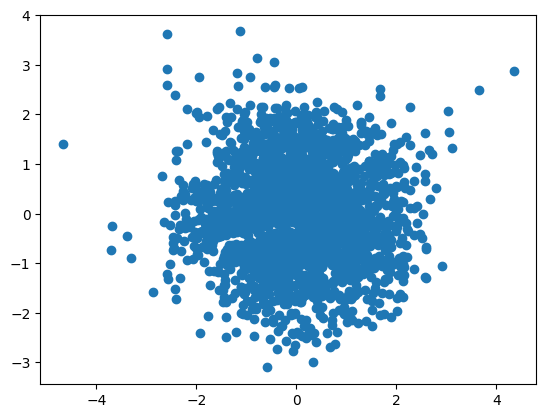

In [13]:
fig=plt.scatter(z[:,0], z[:,1])

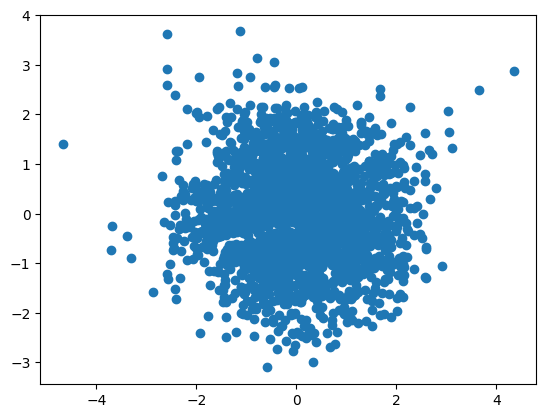

In [ ]:
from matplotlib.animation import FuncAnimation

z = data

fig, ax = plt.subplots()

def animate(i):
    fig.clear()
    ax = fig.add_subplot(111)
    s = ax.scatter(z_list[i][:,0], z_list[i][:,1])

z_list = []
z_list.append(z)
for layer in flow.coupling_layers:
    z, _ = layer(z)
    z_list.append(z)

animation = FuncAnimation(fig, animate, interval=500, frames=range(len(z_list)))
animation.save("normalizing-flow-forward.mp4", writer="ffmpeg")
plt.show()

In [14]:
y = flow.sample(n_samples)

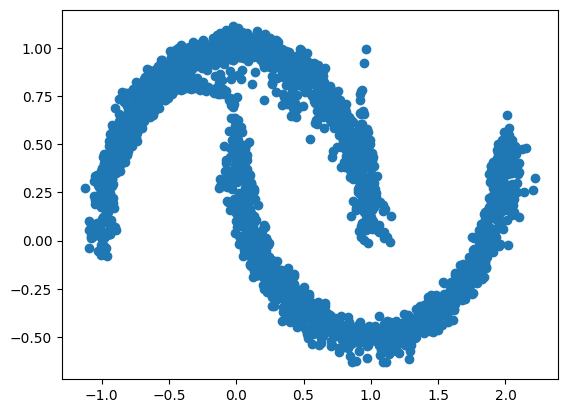

In [15]:
fig = plt.scatter(y[:,0], y[:,1])